In [1]:
!pip install transformers
!pip install contractions
!pip install pyspellchecker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 93.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 44.8 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
import pickle
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import string
import re
import nltk
import contractions
from nltk.tokenize import word_tokenize
from spellchecker import SpellChecker
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer, WordNetLemmatizer

In [3]:
df = pd.read_csv("/content/Extracted_dataset.csv")
df.head()

,0,document,title,abstract
0,0,doc4.pdf,MATERIALS ISSUES OF LOADING DEUTERIUM INTO PAL...,\nthe ability of palladium cathodes to attain ...
1,1,doc15.pdf,ICCF-7,\nlow energy (l-300kev) deuterium ion beam imp...
2,2,doc16.pdf,Nuclear Physics Approach Anomalous Phenomena i...,\nimplantation experiments of very low energy ...
3,3,doc5.pdf,Excess Heat Production and Nuclear Ash in PdO/...,\nheat production nuclear ash and electrophysi...
4,4,doc14.pdf,SEARCH FOR COHERENT DEUTERON FUSION BY BEAM AN...,] procedures and results of three kinds of exp...


In [4]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [7]:
def preprocess_text(text):
  text = text.lower()
  text = re.sub('\d+', '', text)
  # remove punctuations
  punctuations = string.punctuation
  text = text.translate(str.maketrans('', '', punctuations))
  # remove special characters
  special_characters = 'å¼«¥ª°©ð±§µæ¹¢³¿®ä£'
  text = text.translate(str.maketrans('', '', special_characters))
  # Expand contractions
  text = contractions.fix(text)
  # remove stopwords
  tokens = word_tokenize(text)
  tokens = [token for token in tokens if token not in stop_words]
  # Spellcheck
  spelling_checker = SpellChecker(language="en", distance=1)
  #spelling_checker.word_frequency.load_text_file("ignore_spellcheck_words.txt")
  misspelled = spelling_checker.unknown(tokens)
  for word in misspelled:
    temp = spelling_checker.correction(word)
    if temp:
      tokens[tokens.index(word)] = temp
  # Lemmatization
  lemmatizer = WordNetLemmatizer()
  processed_tokens = [lemmatizer.lemmatize(token) for token in tokens]
  text = " ".join(processed_tokens)
  # remove white space
  text = " ".join(text.split()).strip()

  return text

In [8]:
df['abstract'] = df['abstract'].apply(preprocess_text)
df.head()

,0,document,title,abstract
0,0,doc4.pdf,MATERIALS ISSUES OF LOADING DEUTERIUM INTO PAL...,ability palladium cathode attain maintain high...
1,1,doc15.pdf,ICCF-7,low energy lke deuterium ion beam implantation...
2,2,doc16.pdf,Nuclear Physics Approach Anomalous Phenomena i...,implantation experiment low energy lke eke hyd...
3,3,doc5.pdf,Excess Heat Production and Nuclear Ash in PdO/...,heat production nuclear ash electrophysical pr...
4,4,doc14.pdf,SEARCH FOR COHERENT DEUTERON FUSION BY BEAM AN...,procedure result three kind experiment ie clos...


# BERT

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [10]:
model_name = "allenai/scibert_scivocab_uncased" # 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name).to(device)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(31090, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [11]:
for n, row in df.iterrows():
  print(row["document"])
  text = row["title"] + " " + row["abstract"]
  inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt").to(device)
  # print(inputs)
  print(text)
  print(tokenizer.tokenize(text))
  break

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


doc4.pdf
MATERIALS ISSUES OF LOADING DEUTERIUM INTO PALLADIUM AND THE ASSOCIATION WITH EXCESS HEAT PRODUCTION M.C.H. McKubre and F. L. Tanzella SRI International, 333 Ravenswood Avenue, Menlo Park, CA Abstract The ability of palladium cathodes to attain and maintain high loading levels, at high ability palladium cathode attain maintain high loading level high current density long time controlled two factor condition electrochemical interface allows attainment high deuterium activity defect density mechanical condition bulk material permit ad lattice withstand contain high bulk deuterium activity equilibrate produce extreme pressure deuterium gas inside closed incipient void within metal example given set intentionally similar current ramp show three distinct mode loading performance mode linear decrease pd resistance beyond resistance maximum logarithmic increase electrochemical current mode i initial loglinear decrease mode trajectory followed rapid increase resistance resistance fall

In [12]:
res = {}
for n, row in df.iterrows():
  print(row["document"])
  text = row["title"] + " " + row["abstract"]
  inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)
  outputs = model(**inputs)
  embeddings = outputs.pooler_output
  print(embeddings.shape)
  res[row["document"]] = embeddings
  # embeddings.shape

doc4.pdf
torch.Size([1, 768])
doc15.pdf
torch.Size([1, 768])
doc16.pdf
torch.Size([1, 768])
doc5.pdf
torch.Size([1, 768])
doc14.pdf
torch.Size([1, 768])
doc9.pdf
torch.Size([1, 768])
doc12.pdf
torch.Size([1, 768])
doc32.pdf
torch.Size([1, 768])
doc25.pdf
torch.Size([1, 768])
doc1.pdf
torch.Size([1, 768])
doc28.pdf
torch.Size([1, 768])
doc11.pdf
torch.Size([1, 768])
doc8.pdf
torch.Size([1, 768])
doc7.pdf
torch.Size([1, 768])
doc31.pdf
torch.Size([1, 768])
doc27.pdf
torch.Size([1, 768])
doc3.pdf
torch.Size([1, 768])
doc18.pdf
torch.Size([1, 768])
doc17.pdf
torch.Size([1, 768])
doc23.pdf
torch.Size([1, 768])
doc22.pdf
torch.Size([1, 768])
doc26.pdf
torch.Size([1, 768])
doc20.pdf
torch.Size([1, 768])
doc30.pdf
torch.Size([1, 768])
doc29.pdf
torch.Size([1, 768])
doc24.pdf
torch.Size([1, 768])
doc2.pdf
torch.Size([1, 768])
doc13.pdf
torch.Size([1, 768])
doc19.pdf
torch.Size([1, 768])
doc10.pdf
torch.Size([1, 768])


In [13]:
with open('bert_doc_embeddings.pkl', 'wb') as pkl:
    pickle.dump(res, pkl)

In [14]:
doc_embeddings = None
with open('bert_doc_embeddings.pkl', 'rb') as pkl:
    doc_embeddings = pickle.load(pkl)
    print(list(doc_embeddings.keys()))
    print(doc_embeddings["doc1.pdf"].shape)

['doc4.pdf', 'doc15.pdf', 'doc16.pdf', 'doc5.pdf', 'doc14.pdf', 'doc9.pdf', 'doc12.pdf', 'doc32.pdf', 'doc25.pdf', 'doc1.pdf', 'doc28.pdf', 'doc11.pdf', 'doc8.pdf', 'doc7.pdf', 'doc31.pdf', 'doc27.pdf', 'doc3.pdf', 'doc18.pdf', 'doc17.pdf', 'doc23.pdf', 'doc22.pdf', 'doc26.pdf', 'doc20.pdf', 'doc30.pdf', 'doc29.pdf', 'doc24.pdf', 'doc2.pdf', 'doc13.pdf', 'doc19.pdf', 'doc10.pdf']
torch.Size([1, 768])


### scibert

In [15]:
for i in list(doc_embeddings.keys()):
  if "doc1" in i:
    continue
  output = torch.nn.functional.cosine_similarity(doc_embeddings["doc1.pdf"], doc_embeddings[i])
  print(i, output)

doc4.pdf tensor([0.7431], grad_fn=<SumBackward1>)
doc5.pdf tensor([0.8156], grad_fn=<SumBackward1>)
doc9.pdf tensor([0.8798], grad_fn=<SumBackward1>)
doc32.pdf tensor([0.9122], grad_fn=<SumBackward1>)
doc25.pdf tensor([0.9152], grad_fn=<SumBackward1>)
doc28.pdf tensor([0.8806], grad_fn=<SumBackward1>)
doc8.pdf tensor([0.7408], grad_fn=<SumBackward1>)
doc7.pdf tensor([0.7644], grad_fn=<SumBackward1>)
doc31.pdf tensor([0.9165], grad_fn=<SumBackward1>)
doc27.pdf tensor([0.8056], grad_fn=<SumBackward1>)
doc3.pdf tensor([0.6530], grad_fn=<SumBackward1>)
doc23.pdf tensor([0.6686], grad_fn=<SumBackward1>)
doc22.pdf tensor([0.6177], grad_fn=<SumBackward1>)
doc26.pdf tensor([0.8301], grad_fn=<SumBackward1>)
doc20.pdf tensor([0.7931], grad_fn=<SumBackward1>)
doc30.pdf tensor([0.8274], grad_fn=<SumBackward1>)
doc29.pdf tensor([0.9177], grad_fn=<SumBackward1>)
doc24.pdf tensor([0.8305], grad_fn=<SumBackward1>)
doc2.pdf tensor([0.9323], grad_fn=<SumBackward1>)


### bert-base

In [16]:
for i in list(doc_embeddings.keys()):
  if "doc1" in i:
    continue
  output = torch.nn.functional.cosine_similarity(doc_embeddings["doc1.pdf"], doc_embeddings[i])
  print(i, output)

doc4.pdf tensor([0.7431], grad_fn=<SumBackward1>)
doc5.pdf tensor([0.8156], grad_fn=<SumBackward1>)
doc9.pdf tensor([0.8798], grad_fn=<SumBackward1>)
doc32.pdf tensor([0.9122], grad_fn=<SumBackward1>)
doc25.pdf tensor([0.9152], grad_fn=<SumBackward1>)
doc28.pdf tensor([0.8806], grad_fn=<SumBackward1>)
doc8.pdf tensor([0.7408], grad_fn=<SumBackward1>)
doc7.pdf tensor([0.7644], grad_fn=<SumBackward1>)
doc31.pdf tensor([0.9165], grad_fn=<SumBackward1>)
doc27.pdf tensor([0.8056], grad_fn=<SumBackward1>)
doc3.pdf tensor([0.6530], grad_fn=<SumBackward1>)
doc23.pdf tensor([0.6686], grad_fn=<SumBackward1>)
doc22.pdf tensor([0.6177], grad_fn=<SumBackward1>)
doc26.pdf tensor([0.8301], grad_fn=<SumBackward1>)
doc20.pdf tensor([0.7931], grad_fn=<SumBackward1>)
doc30.pdf tensor([0.8274], grad_fn=<SumBackward1>)
doc29.pdf tensor([0.9177], grad_fn=<SumBackward1>)
doc24.pdf tensor([0.8305], grad_fn=<SumBackward1>)
doc2.pdf tensor([0.9323], grad_fn=<SumBackward1>)


# Word2Vec training

In [17]:
from scipy import spatial
import numpy as np
from gensim.models import Word2Vec

def preprocess(s):
  return [i.lower() for i in s.split()]

def get_vector(s):
  return np.sum(np.array([model.wv[i] for i in preprocess(s)]), axis=0)

text_data = []
for n, row in df.iterrows():
  text = row["title"] + " " + row["abstract"]
  text_data.append(preprocess(text))

model = Word2Vec(sentences=text_data, vector_size=200, window=5, min_count=1, workers=4)

res = {}
for n, row in df.iterrows():
  print(row["document"])
  text = row["title"] + " " + row["abstract"]
  embeddings = get_vector(text)
  print(len(embeddings))
  res[row["document"]] = embeddings

doc4.pdf
200
doc15.pdf
200
doc16.pdf
200
doc5.pdf
200
doc14.pdf
200
doc9.pdf
200
doc12.pdf
200
doc32.pdf
200
doc25.pdf
200
doc1.pdf
200
doc28.pdf
200
doc11.pdf
200
doc8.pdf
200
doc7.pdf
200
doc31.pdf
200
doc27.pdf
200
doc3.pdf
200
doc18.pdf
200
doc17.pdf
200
doc23.pdf
200
doc22.pdf
200
doc26.pdf
200
doc20.pdf
200
doc30.pdf
200
doc29.pdf
200
doc24.pdf
200
doc2.pdf
200
doc13.pdf
200
doc19.pdf
200
doc10.pdf
200


In [18]:
with open('word2vec_doc_embeddings.pkl', 'wb') as pkl:
    pickle.dump(res, pkl)

In [19]:
doc_embeddings = None
with open('word2vec_doc_embeddings.pkl', 'rb') as pkl:
    doc_embeddings = pickle.load(pkl)
    print(list(doc_embeddings.keys()))
    print(doc_embeddings["doc1.pdf"].shape)

['doc4.pdf', 'doc15.pdf', 'doc16.pdf', 'doc5.pdf', 'doc14.pdf', 'doc9.pdf', 'doc12.pdf', 'doc32.pdf', 'doc25.pdf', 'doc1.pdf', 'doc28.pdf', 'doc11.pdf', 'doc8.pdf', 'doc7.pdf', 'doc31.pdf', 'doc27.pdf', 'doc3.pdf', 'doc18.pdf', 'doc17.pdf', 'doc23.pdf', 'doc22.pdf', 'doc26.pdf', 'doc20.pdf', 'doc30.pdf', 'doc29.pdf', 'doc24.pdf', 'doc2.pdf', 'doc13.pdf', 'doc19.pdf', 'doc10.pdf']
(200,)


In [20]:
for i in list(doc_embeddings.keys()):
  if "doc1" in i:
    continue
  output = 1 - spatial.distance.cosine(doc_embeddings["doc1.pdf"], doc_embeddings[i])
  print(i, output)

doc4.pdf 0.49424341320991516
doc5.pdf 0.6042689085006714
doc9.pdf 0.4217040240764618
doc32.pdf 0.5237597823143005
doc25.pdf 0.47614628076553345
doc28.pdf 0.4799894392490387
doc8.pdf 0.5207076072692871
doc7.pdf 0.5906774401664734
doc31.pdf 0.3340543210506439
doc27.pdf 0.5779787302017212
doc3.pdf 0.6269906163215637
doc23.pdf 0.5350211262702942
doc22.pdf 0.5270212888717651
doc26.pdf 0.44410115480422974
doc20.pdf 0.4905087649822235
doc30.pdf 0.538537323474884
doc29.pdf 0.385328084230423
doc24.pdf 0.44897982478141785
doc2.pdf 0.6708626747131348


# Glove pre-trained

In [21]:
from scipy import spatial
import numpy as np
from gensim.models import Word2Vec
import gensim.downloader

model = gensim.downloader.load('glove-wiki-gigaword-200')

[==================================================] 100.0% 252.1/252.1MB downloaded


In [22]:
"dog" in list(model.key_to_index.keys())

True

In [23]:
len(model["dog"])

200

In [24]:
from scipy import spatial
import numpy as np
from gensim.models import Word2Vec
import gensim

def preprocess(s):
  return [i.lower() for i in s.split()]

def get_vector(s):
  return np.sum(np.array([model[i] for i in preprocess(s) if i in list(model.key_to_index.keys())]), axis=0)

# model = gensim.downloader.load('glove-wiki-gigaword-200')

res = {}
for n, row in df.iterrows():
  print(row["document"])
  text = row["title"] + " " + row["abstract"]
  embeddings = get_vector(text)
  print(len(embeddings))
  res[row["document"]] = embeddings
# model.__dir__()

doc4.pdf
200
doc15.pdf
200
doc16.pdf
200
doc5.pdf
200
doc14.pdf
200
doc9.pdf
200
doc12.pdf
200
doc32.pdf
200
doc25.pdf
200
doc1.pdf
200
doc28.pdf
200
doc11.pdf
200
doc8.pdf
200
doc7.pdf
200
doc31.pdf
200
doc27.pdf
200
doc3.pdf
200
doc18.pdf
200
doc17.pdf
200
doc23.pdf
200
doc22.pdf
200
doc26.pdf
200
doc20.pdf
200
doc30.pdf
200
doc29.pdf
200
doc24.pdf
200
doc2.pdf
200
doc13.pdf
200
doc19.pdf
200
doc10.pdf
200


In [25]:
with open('pretrained_glove_doc_embeddings.pkl', 'wb') as pkl:
    pickle.dump(res, pkl)

In [26]:
doc_embeddings = None
with open('pretrained_glove_doc_embeddings.pkl', 'rb') as pkl:
    doc_embeddings = pickle.load(pkl)
    print(list(doc_embeddings.keys()))
    print(doc_embeddings["doc1.pdf"].shape)

['doc4.pdf', 'doc15.pdf', 'doc16.pdf', 'doc5.pdf', 'doc14.pdf', 'doc9.pdf', 'doc12.pdf', 'doc32.pdf', 'doc25.pdf', 'doc1.pdf', 'doc28.pdf', 'doc11.pdf', 'doc8.pdf', 'doc7.pdf', 'doc31.pdf', 'doc27.pdf', 'doc3.pdf', 'doc18.pdf', 'doc17.pdf', 'doc23.pdf', 'doc22.pdf', 'doc26.pdf', 'doc20.pdf', 'doc30.pdf', 'doc29.pdf', 'doc24.pdf', 'doc2.pdf', 'doc13.pdf', 'doc19.pdf', 'doc10.pdf']
(200,)


In [27]:
for i in list(doc_embeddings.keys()):
  if "doc1" in i:
    continue
  output = 1 - spatial.distance.cosine(doc_embeddings["doc1.pdf"], doc_embeddings[i])
  print(i, output)

doc4.pdf 0.9436064958572388
doc5.pdf 0.8735416531562805
doc9.pdf 0.9163336157798767
doc32.pdf 0.9503900408744812
doc25.pdf 0.9260703921318054
doc28.pdf 0.9112688302993774
doc8.pdf 0.9328381419181824
doc7.pdf 0.9340457320213318
doc31.pdf 0.9211826324462891
doc27.pdf 0.8955433368682861
doc3.pdf 0.9163644313812256
doc23.pdf 0.874739944934845
doc22.pdf 0.895529568195343
doc26.pdf 0.8631941080093384
doc20.pdf 0.8853211402893066
doc30.pdf 0.9291488528251648
doc29.pdf 0.9036635756492615
doc24.pdf 0.9072354435920715
doc2.pdf 0.9790905714035034


# Dimensionality reduction

In [28]:
doc_embeddings = None
with open('bert_doc_embeddings.pkl', 'rb') as pkl:
    doc_embeddings = pickle.load(pkl)
    print(list(doc_embeddings.keys()))
    print(doc_embeddings["doc1.pdf"].shape)

['doc4.pdf', 'doc15.pdf', 'doc16.pdf', 'doc5.pdf', 'doc14.pdf', 'doc9.pdf', 'doc12.pdf', 'doc32.pdf', 'doc25.pdf', 'doc1.pdf', 'doc28.pdf', 'doc11.pdf', 'doc8.pdf', 'doc7.pdf', 'doc31.pdf', 'doc27.pdf', 'doc3.pdf', 'doc18.pdf', 'doc17.pdf', 'doc23.pdf', 'doc22.pdf', 'doc26.pdf', 'doc20.pdf', 'doc30.pdf', 'doc29.pdf', 'doc24.pdf', 'doc2.pdf', 'doc13.pdf', 'doc19.pdf', 'doc10.pdf']
torch.Size([1, 768])


In [29]:
# doc_embeddings["doc1.pdf"][0]

In [30]:
embed_vals = list(doc_embeddings.values())
embed_vals = [i[0].detach().numpy() for i in embed_vals]
embed_vals[0]

array([-3.63233268e-01, -3.20249707e-01, -3.48136008e-01, -9.73146260e-02,
        3.84096175e-01,  9.99981821e-01,  5.15508592e-01, -9.99671757e-01,
        3.13856483e-01,  7.19825268e-01,  4.81250405e-01,  3.95206600e-01,
        9.53679383e-01, -2.89808720e-01,  1.85241640e-01, -1.16694801e-01,
       -3.94342989e-01, -3.71777594e-01, -1.97971389e-01, -9.07053828e-01,
       -1.20734483e-01,  5.64557016e-01,  8.70078504e-01,  3.81095827e-01,
       -9.52100635e-01,  9.72671449e-01, -5.23244143e-01,  1.11590184e-01,
       -4.25053358e-01,  4.37912613e-01,  4.20548081e-01, -9.60838377e-01,
        2.87842155e-01, -2.56144434e-01, -2.52333432e-01,  2.35649675e-01,
        9.99773264e-01,  1.92427039e-01,  3.10626715e-01,  6.59585297e-01,
       -3.35688770e-01,  3.73955309e-01,  1.72253523e-03,  4.03287970e-02,
        5.09736538e-01, -3.71651322e-01, -1.48323655e-01,  1.11851268e-01,
        5.04139483e-01,  7.13257790e-01,  8.86335894e-02, -4.19687837e-01,
       -2.18916088e-02,  

In [31]:
from sklearn.decomposition import PCA

pca = PCA(n_components=30)
values = pca.fit_transform(embed_vals)
values.shape

(30, 30)

In [35]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=29)
values = lle.fit_transform(embed_vals)
values.shape

(30, 29)

# Clustering

In [36]:
import numpy as np

from sklearn import metrics
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=1.5, min_samples=2).fit(values)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 1
Estimated number of noise points: 0


In [37]:
from sklearn.cluster import Birch

brc = Birch(n_clusters=5)
brc.fit(values)
brc.predict(values)

array([0, 4, 0, 2, 0, 2, 1, 2, 0, 1, 3, 0, 0, 0, 0, 0, 2, 0, 0, 3, 1, 0,
       4, 4, 3, 1, 0, 2, 1, 0])

In [38]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(values)
print(kmeans.labels_)
# kmeans.predict(values)
# kmeans.cluster_centers_

[0 1 1 2 0 2 0 2 2 2 0 1 0 1 2 2 1 2 1 2 1 0 2 1 1 2 2 0 2 0]


# Visualization

In [ ]:
# TSNE for visualisation

In [39]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

In [40]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(values)
df = {}
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1]
df['pca-three'] = pca_result[:,2]
df["labels"] = brc.predict(values)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.03448276 0.03448276 0.03448276]


<Axes: xlabel='pca-one', ylabel='pca-two'>

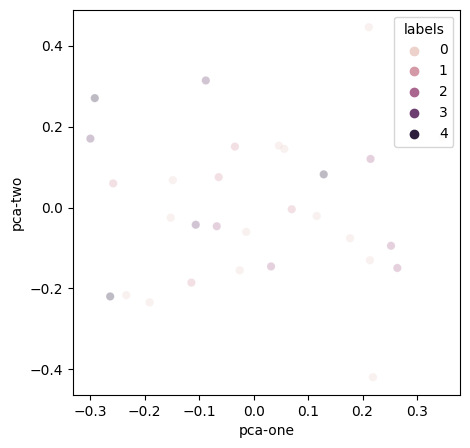

In [41]:
plt.figure(figsize=(5,5))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="labels",
    # palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)

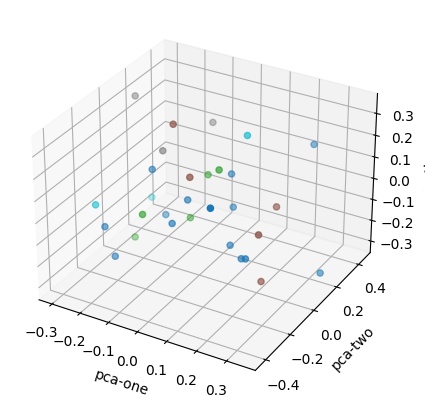

In [42]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
ax.scatter(
    xs=df["pca-one"],
    ys=df["pca-two"],
    zs=df["pca-three"],
    c=df["labels"],
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [44]:
tsne = TSNE(n_components=3, verbose=1, perplexity=29, n_iter=300)
tsne_results = tsne.fit_transform(values)
df['tsne-one'] = tsne_results[:,0]
df['tsne-two'] = tsne_results[:,1]
df['tsne-three'] = tsne_results[:,2]

[t-SNE] Computing 29 nearest neighbors...
[t-SNE] Indexed 30 samples in 0.001s...
[t-SNE] Computed neighbors for 30 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 30 / 30
[t-SNE] Mean sigma: 1.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.321465
[t-SNE] KL divergence after 300 iterations: 0.738524


<Axes: xlabel='tsne-one', ylabel='tsne-two'>

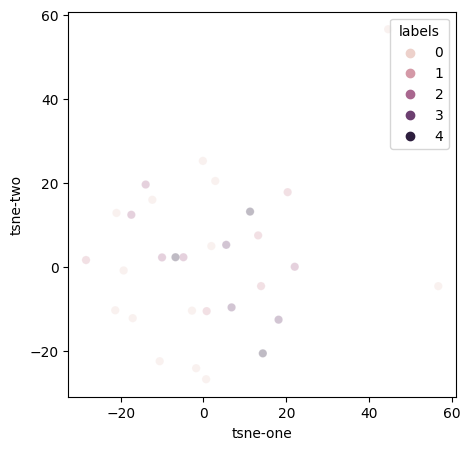

In [45]:
plt.figure(figsize=(5,5))
sns.scatterplot(
    x="tsne-one", y="tsne-two",
    hue="labels",
    # palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)

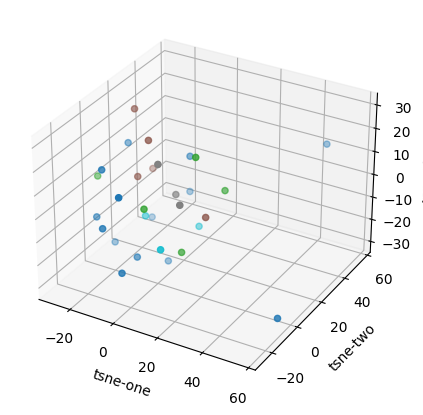

In [46]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
ax.scatter(
    xs=df["tsne-one"],
    ys=df["tsne-two"],
    zs=df["tsne-three"],
    c=df["labels"],
    cmap='tab10'
)
ax.set_xlabel('tsne-one')
ax.set_ylabel('tsne-two')
ax.set_zlabel('tsne-three')
plt.show()

In [47]:
kmeans.labels_

array([0, 1, 1, 2, 0, 2, 0, 2, 2, 2, 0, 1, 0, 1, 2, 2, 1, 2, 1, 2, 1, 0,
       2, 1, 1, 2, 2, 0, 2, 0], dtype=int32)

# TF-IDF

In [48]:
TOP_K_KEYWORDS = 6

In [49]:
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []

    for idx, score in sorted_items:
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    return results

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def get_keywords(vectorizer, feature_names, doc):
    tf_idf_vector = vectorizer.transform(doc)
    sorted_items=sort_coo(tf_idf_vector.tocoo())
    keywords=extract_topn_from_vector(feature_names,sorted_items,TOP_K_KEYWORDS)
    return list(keywords.keys())

In [50]:
stop_words = list(set(stopwords.words('english')))

In [53]:
df


{'pca-one': array([ 0.05644368,  0.12876354,  0.21357622, -0.0675728 ,  0.11597988,
         0.25226909, -0.06405756,  0.26386119, -0.19073511,  0.0700624 ,
        -0.08765862, -0.23360453,  0.17715022,  0.04649418,  0.21161673,
        -0.02541967,  0.21470822, -0.15211034, -0.01345492, -0.29951666,
        -0.03421233,  0.21913764, -0.263204  , -0.29146743, -0.10616478,
        -0.25767586, -0.14823806,  0.03210088, -0.11415439,  0.34708321]),
 'pca-two': array([ 0.14510049,  0.08199857, -0.13035296, -0.04625398, -0.02107278,
        -0.09452659,  0.07511201, -0.14942375, -0.23451578, -0.0042463 ,
         0.31406281, -0.21662566, -0.07586895,  0.15281443,  0.44568833,
        -0.15525028,  0.12013261, -0.02514439, -0.06013957,  0.17032048,
         0.1506075 , -0.41949416, -0.21978503,  0.2704298 , -0.042556  ,
         0.05967094,  0.06752057, -0.14565827, -0.18558179,  0.17303767]),
 'pca-three': array([-0.08419235,  0.30318364, -0.11954855,  0.34257718, -0.15421409,
        -0.2

In [54]:
df = pd.read_csv("/content/Extracted_dataset.csv")
df.head()

,0,document,title,abstract
0,0,doc4.pdf,MATERIALS ISSUES OF LOADING DEUTERIUM INTO PAL...,\nthe ability of palladium cathodes to attain ...
1,1,doc15.pdf,ICCF-7,\nlow energy (l-300kev) deuterium ion beam imp...
2,2,doc16.pdf,Nuclear Physics Approach Anomalous Phenomena i...,\nimplantation experiments of very low energy ...
3,3,doc5.pdf,Excess Heat Production and Nuclear Ash in PdO/...,\nheat production nuclear ash and electrophysi...
4,4,doc14.pdf,SEARCH FOR COHERENT DEUTERON FUSION BY BEAM AN...,] procedures and results of three kinds of exp...


In [55]:
corpora = df["abstract"].to_list()

In [56]:
vectorizer = TfidfVectorizer(stop_words=stop_words, smooth_idf=True, use_idf=True)
vectorizer.fit_transform(corpora)

feature_names = vectorizer.get_feature_names_out()

In [ ]:
top_keywords = []
abstracts_temp = [[]]
for n, row in df.iterrows():
  abstracts_temp[-1].append(row["abstract"])
  if len(abstracts_temp[-1]) == 5:
      abstracts_temp.append([])

for i in abstracts_temp:
    top_keywords.append(get_keywords(vectorizer, feature_names, i))
print(list(enumerate(top_keywords)))